In [1]:
!nvidia-smi

Tue Sep 29 21:59:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 451.67       Driver Version: 451.67       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 2080   WDDM  | 00000000:01:00.0  On |                  N/A |
| 33%   40C    P8    21W / 225W |    401MiB /  8192MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

# Imports and Utility functions

## <font color='orange'>Imports</font>

In [1]:
import numpy as np
import pandas as pd
import shutil, time, os, requests, random, copy, pickle
from itertools import permutations 
import seaborn as sns
import imageio
from skimage.transform import rotate, AffineTransform, warp, resize
#from google.colab.patches import cv2_imshow
from IPython.display import clear_output, Image, SVG
import h5py

#%tensorflow_version 2.x
%load_ext tensorboard
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, GlobalAveragePooling2D, AveragePooling2D, BatchNormalization, Reshape

#from tensorflow.keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D, AveragePooling3D

from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Concatenate, Lambda, LeakyReLU, ConvLSTM2D

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers, activations
from tensorflow.keras.utils import to_categorical, Sequence

from tensorflow.keras.utils import plot_model
#from tensorflow.keras.utils import model_to_dot
#from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
#from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
#import matplotlib.animation as animation
%matplotlib inline

In [3]:
#from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as ppi_irv2

In [ ]:
!nvidia-smi

## <font color='orange'>Analysing and Cleaning Data</font>

### Files

In [5]:
mrnet_path = '.\Datasets\MRNet\MRNet-v1.0'
contents = os.listdir(mrnet_path)
print(contents)
print('\nLabel Files...')
label_files = [x for x in contents if x.endswith('.csv')]
print(label_files)

['.DS_Store', 'train', 'train-abnormal.csv', 'train-acl.csv', 'train-meniscus.csv', 'valid', 'valid-abnormal.csv', 'valid-acl.csv', 'valid-meniscus.csv']

Label Files...
['train-abnormal.csv', 'train-acl.csv', 'train-meniscus.csv', 'valid-abnormal.csv', 'valid-acl.csv', 'valid-meniscus.csv']


### Real Labels

In [6]:
#For Colab /root/MRNet/MRNet-v1.0/
trabn = pd.read_csv(mrnet_path+'\\train-abnormal.csv',header=None)
#trabn.head()
tracl = pd.read_csv(mrnet_path+'\\train-acl.csv',header=None)
#tracl.head()
trmen = pd.read_csv(mrnet_path+'\\train-meniscus.csv',header=None)
#trmen.head()

In [7]:
trabn.columns = ['patient_id','label']
tracl.columns = ['patient_id','label']
trmen.columns = ['patient_id','label']

In [8]:
tr_multilabel = trabn.merge(tracl,on='patient_id').merge(trmen,on='patient_id')
tr_multilabel.columns = ['patient_id','abn','acl','men']
tr_multilabel.head()

,patient_id,abn,acl,men
0,0,1,0,0
1,1,1,1,1
2,2,1,0,0
3,3,1,0,1
4,4,1,0,0


In [9]:
#For Colab /root/MRNet/MRNet-v1.0/
valabn = pd.read_csv(mrnet_path+'\\valid-abnormal.csv',header=None)
valacl = pd.read_csv(mrnet_path+'\\valid-acl.csv',header=None)
valmen = pd.read_csv(mrnet_path+'\\valid-meniscus.csv',header=None)

In [10]:
valabn.columns = ['patient_id','label']
valacl.columns = ['patient_id','label']
valmen.columns = ['patient_id','label']

In [11]:
val_multilabel = valabn.merge(valacl,on='patient_id').merge(valmen,on='patient_id')
val_multilabel.columns = ['patient_id','abn','acl','men']
val_multilabel.head(120)

,patient_id,abn,acl,men
0,1130,0,0,0
1,1131,0,0,0
2,1132,0,0,0
3,1133,0,0,0
4,1134,0,0,0
...,...,...,...,...
115,1245,1,1,1
116,1246,1,1,1
117,1247,1,0,1
118,1248,1,1,1


### <font color='blue'>Filename DataFrame</font>

In [12]:
tr_filenames_df = pd.DataFrame(columns=['filename'])
tr_filenames_df['filename'] = os.listdir(mrnet_path+'\\train\\axial')
tr_filenames_df['patient_id'] = tr_filenames_df.apply(lambda x : int(x['filename'][:-4]),axis=1)
tr_filenames_df = tr_filenames_df[list(('patient_id','filename'))]
tr_filenames_df.sort_values(by=['patient_id'],ascending=True,inplace=True,ignore_index=True)

tr_filenames_df

,patient_id,filename
0,0,0000.npy
1,1,0001.npy
2,2,0002.npy
3,3,0003.npy
4,4,0004.npy
...,...,...
1125,1125,1125.npy
1126,1126,1126.npy
1127,1127,1127.npy
1128,1128,1128.npy


In [13]:
val_filenames_df = pd.DataFrame(columns=['filename'])
val_filenames_df['filename'] = os.listdir(mrnet_path+'\\valid\\axial')
val_filenames_df['patient_id'] = val_filenames_df.apply(lambda x : int(x['filename'][:-4]),axis=1)
val_filenames_df = val_filenames_df[list(('patient_id','filename'))]
val_filenames_df.sort_values(by=['patient_id'],ascending=True,inplace=True,ignore_index=True)

val_filenames_df

,patient_id,filename
0,1130,1130.npy
1,1131,1131.npy
2,1132,1132.npy
3,1133,1133.npy
4,1134,1134.npy
...,...,...
115,1245,1245.npy
116,1246,1246.npy
117,1247,1247.npy
118,1248,1248.npy


## <font color='orange'>Utility Functions</font>

### <font color='blue'>Declaring the required PATH variables</font>

In [14]:
#For Colab '/root/MRNet/MRNet-v1.0/'

train_dir = mrnet_path+'\\train'
valid_dir = mrnet_path+'\\valid'
axial_mode= 'axial'
sagit_mode='sagittal'
coron_mode='coronal'
base_dir = mrnet_path

NUM_FRAMES = 16
batch_size = 1 #32
NUM_CLASSES = 3
NUM_PATCHES = 9

## Callback

In [15]:
#os.makedirs('saved_models/')

def get_callbacks():
    save_dir = './saved_model/'
    model_name = '/path/to/best/model.h5'

    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+model_name, monitor='val_binary_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

    '''reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=4, 
                                   verbose=1, mode='max', min_lr=0.00001)'''
                              
    early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10)

    callbacks_list = [checkpoint, early]

    return callbacks_list

### <font color='blue'>Performance Metrics</font>

In [16]:
#util_wk2
def TP(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 1))


def TN(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 0))


def FN(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 1))


def FP(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 0))

def get_accuracy(y, pred, th=0.5):
    tp = TP(y,pred,th)
    fp = FP(y,pred,th)
    tn = TN(y,pred,th)
    fn = FN(y,pred,th)
    
    return (tp+tn)/(tp+fp+tn+fn)

def get_prevalence(y):
    return np.sum(y)/y.shape[0]

def sensitivity(y, pred, th=0.5):
    tp = TP(y,pred,th)
    fn = FN(y,pred,th)
    
    return tp/(tp+fn)

def specificity(y, pred, th=0.5):
    tn = TN(y,pred,th)
    fp = FP(y,pred,th)
    
    return tn/(tn+fp)

def get_ppv(y, pred, th=0.5):
    tp = TP(y,pred,th)
    fp = FP(y,pred,th)
    
    return tp/(tp+fp)

def get_npv(y, pred, th=0.5):
    tn = TN(y,pred,th)
    fn = FN(y,pred,th)
    
    return tn/(tn+fn)


def get_performance_metrics(y, pred, class_labels, tp=TP,
                            tn=TN, fp=FP,
                            fn=FN,
                            acc=get_accuracy, prevalence=get_prevalence, 
                            spec=specificity,sens=sensitivity, ppv=get_ppv, 
                            npv=get_npv, auc=roc_auc_score, f1=f1_score,
                            thresholds=[]):
    if len(thresholds) != len(class_labels):
        thresholds = [.5] * len(class_labels)

    columns = ["", "TP", "TN", "FP", "FN", "Accuracy", "Prevalence",
               "Sensitivity",
               "Specificity", "PPV", "NPV", "AUC", "F1", "Threshold"]
    df = pd.DataFrame(columns=columns)
    for i in range(len(class_labels)):
        df.loc[i] = [""] + [0] * (len(columns) - 1)
        df.loc[i][0] = class_labels[i]
        df.loc[i][1] = round(tp(y[:, i], pred[:, i]),
                             3) if tp != None else "Not Defined"
        df.loc[i][2] = round(tn(y[:, i], pred[:, i]),
                             3) if tn != None else "Not Defined"
        df.loc[i][3] = round(fp(y[:, i], pred[:, i]),
                             3) if fp != None else "Not Defined"
        df.loc[i][4] = round(fn(y[:, i], pred[:, i]),
                             3) if fn != None else "Not Defined"
        df.loc[i][5] = round(acc(y[:, i], pred[:, i], thresholds[i]),
                             3) if acc != None else "Not Defined"
        df.loc[i][6] = round(prevalence(y[:, i]),
                             3) if prevalence != None else "Not Defined"
        df.loc[i][7] = round(sens(y[:, i], pred[:, i], thresholds[i]),
                             3) if sens != None else "Not Defined"
        df.loc[i][8] = round(spec(y[:, i], pred[:, i], thresholds[i]),
                             3) if spec != None else "Not Defined"
        df.loc[i][9] = round(ppv(y[:, i], pred[:, i], thresholds[i]),
                             3) if ppv != None else "Not Defined"
        df.loc[i][10] = round(npv(y[:, i], pred[:, i], thresholds[i]),
                              3) if npv != None else "Not Defined"
        df.loc[i][11] = round(auc(y[:, i], pred[:, i]),
                              3) if auc != None else "Not Defined"
        df.loc[i][12] = round(f1(y[:, i], pred[:, i] > thresholds[i]),
                              3) if f1 != None else "Not Defined"
        df.loc[i][13] = round(thresholds[i], 3)

    df = df.set_index("")
    return df

def bootstrap_metric(y, pred, classes, metric='AUC',bootstraps = 100, fold_size = 1000):
    statistics = np.zeros((len(classes), bootstraps))
    if metric=='AUC':
        metric_func = roc_auc_score
    if metric=='Sensitivity':
        metric_func = sensitivity
    if metric=='Specificity':
        metric_func = specificity
    if metric=='Accuracy':
        metric_func = get_accuracy
    for c in range(len(classes)):
        df = pd.DataFrame(columns=['y', 'pred'])
        df.loc[:, 'y'] = y[:, c]
        df.loc[:, 'pred'] = pred[:, c]
        # get positive examples for stratified sampling
        df_pos = df[df.y == 1]
        df_neg = df[df.y == 0]
        prevalence = len(df_pos) / len(df)
        for i in range(bootstraps):
            # stratified sampling of positive and negative examples
            pos_sample = df_pos.sample(n = int(fold_size * prevalence), replace=True)
            neg_sample = df_neg.sample(n = int(fold_size * (1-prevalence)), replace=True)

            y_sample = np.concatenate([pos_sample.y.values, neg_sample.y.values])
            pred_sample = np.concatenate([pos_sample.pred.values, neg_sample.pred.values])
            score = metric_func(y_sample, pred_sample)
            statistics[c][i] = score
    return statistics

def get_confidence_intervals(y,pred,class_labels):
    
    metric_dfs = {}
    for metric in ['AUC','Sensitivity','Specificity','Accuracy']:
        statistics = bootstrap_metric(y,pred,class_labels,metric)
        df = pd.DataFrame(columns=["Mean "+metric+" (CI 5%-95%)"])
        for i in range(len(class_labels)):
            mean = statistics.mean(axis=1)[i]
            max_ = np.quantile(statistics, .95, axis=1)[i]
            min_ = np.quantile(statistics, .05, axis=1)[i]
            df.loc[class_labels[i]] = ["%.4f (%.4f-%.4f)" % (mean, min_, max_)]
        metric_dfs[metric] = df
    return metric_dfs


### <font color='blue'>Plotting Metrics</font>

#### <font color='red'>Accuracy</font>

In [18]:
def plot_accuracy(tr_acc,val_acc):
    # Plot training & validation accuracy values
    plt.plot(tr_acc)
    plt.plot(val_acc)
    plt.title('Model accuracy',fontsize=10)
    plt.ylabel('Accuracy',fontsize=10)
    plt.xlabel('Epoch',fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.legend(['Train', 'Validation'], loc='upper left',prop={'size': 10})
    plt.savefig('accuracy_plot.png')
    plt.show()

#### <font color='red'>Loss</font>

In [19]:
def plot_loss(tr_loss,val_loss):
    # Plot training & validation loss values
    plt.plot(tr_loss)
    plt.plot(val_loss)
    plt.title('Model loss',fontsize=10)
    plt.ylabel('Loss',fontsize=10)
    plt.xlabel('Epoch',fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.legend(['Train', 'Validation'], loc='upper left',prop={'size': 10})
    plt.savefig('loss_plot.png')
    plt.show()


#### <font color='red'>ROC</font>

In [20]:
def get_roc_curve(gt, pred, target_names):
    for i in range(len(target_names)):
        curve_function = roc_curve
        auc_roc = roc_auc_score(gt[:, i], pred[:, i])
        label = str(target_names[i]) + " AUC: %.3f " % auc_roc
        xlabel = "False positive rate"
        ylabel = "True positive rate"
        a, b, _ = curve_function(gt[:, i], pred[:, i])
        plt.figure(1, figsize=(7, 7))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(a, b, label=label)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)
        plt.savefig('ROC_Curve.png')
        plt.show()

#### <font color='red'>Precision and Recall</font>

In [21]:
def get_PR_curve(gt, pred, target_names):
    for i in range(len(target_names)):
        precision, recall, _ = precision_recall_curve(gt[:, i], pred[:, i])
        average_precision = average_precision_score(gt[:, i], pred[:, i])
        label = str(target_names[i]) + " Avg.: %.3f " % average_precision
        plt.figure(1, figsize=(7, 7))
        plt.step(recall, precision, where='post', label=label)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)
        plt.savefig('Precision_and_Recall_curve.png')
        plt.show()

#### <font color='red'>Confusion Matrix</font>  

In [22]:
def plot_confusion_matrix(y_true,y_pred,class_labels):
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=(60,60))
    sns.set(font_scale=3.0) # Adjust to fit
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    ax.tick_params(axis='both', which='major', labelsize=10)  # Adjust to fit
    ax.xaxis.set_ticklabels(class_labels)
    ax.yaxis.set_ticklabels(class_labels)
    fig.savefig('Confusion_Matrix.png')
    plt.show()

#### <font color='red'>Performance Metrics with Errorbars</font>

In [23]:
#04_03_Errorbar.ipynb
def plot_perf_metrics_errbars(y,pred,class_labels):
    metric_dfs = get_confidence_intervals(y,pred,class_labels)
    metrics = list(metric_dfs.keys())
    fig,axs = plt.subplots(len(metrics),1,sharey=True,figsize=(10,40))
    for i in range(len(metrics)):
        ci = metric_dfs[metrics[i]][['Mean '+metrics[i]+' (CI 5%-95%)']].values[0][0]
        print(ci)
        ci_mean,ci_ints = ci.split(' ')
        ci_mean = float(ci_mean)
        print(ci_mean,ci_ints)
        ci_min,ci_max = list(map(float,ci_ints.strip('()').split('-')))
        ci_err = (ci_max-ci_min)/2
        
        axs[i].errorbar(class_labels,ci_mean,yerr=ci_err,capsize=5,fmt='dk')
        axs[i].set_ylabel(metrics[i])
        axs[i].set_ylim([ci_min-0.05,ci_max+0.05])
    fig.savefig('Performance_Metrics_95percentCI.png')
    plt.show()

## Downstream Task Multi-Label Classification (Use Binary Crossentropy)

### Load Models

In [17]:
model_path = 'D:\\SiladittyaJRF\\saved_models\\'

### Class weights

In [19]:
abnNUM_1 = np.count_nonzero(tr_multilabel['abn']==1)
abnNUM_0 = np.count_nonzero(tr_multilabel['abn']==0)
print(abnNUM_1,abnNUM_0)
aclNUM_1 = np.count_nonzero(tr_multilabel['acl']==1)
aclNUM_0 = np.count_nonzero(tr_multilabel['acl']==0)
print(aclNUM_1,aclNUM_0)
menNUM_1 = np.count_nonzero(tr_multilabel['men']==1)
menNUM_0 = np.count_nonzero(tr_multilabel['men']==0)
print(menNUM_1,menNUM_0)

913 217
208 922
397 733


In [20]:
cw = np.array([[abnNUM_1,abnNUM_0],[aclNUM_1,aclNUM_0],[menNUM_1,menNUM_0]])
cw = cw/np.sum(cw,axis=1,keepdims=True)
cw = 1/cw
cw = cw/np.min(cw,axis=1,keepdims=True)
print(cw)

[[1.         4.20737327]
 [4.43269231 1.        ]
 [1.84634761 1.        ]]


0.1


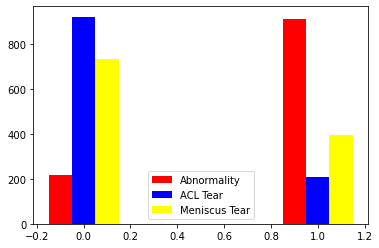

In [21]:
fig, ax = plt.subplots()

abn_heights, abn_bins = np.histogram(tr_multilabel['abn'],bins=[-0.5,0.5,1.5])
acl_heights, acl_bins = np.histogram(tr_multilabel['acl'], bins=abn_bins)
men_heights, men_bins = np.histogram(tr_multilabel['men'], bins=acl_bins)

width = (abn_bins[1] - abn_bins[0])/10.0
print(width)

ax.bar(abn_bins[:-1]-width+0.5, abn_heights, width=width, facecolor='red')
ax.bar(acl_bins[:-1]+0.5, acl_heights, width=width, facecolor='blue')
ax.bar(men_bins[:-1]+width+0.5, men_heights, width=width, facecolor='yellow')

ax.legend(['Abnormality','ACL Tear','Meniscus Tear'])

### Data Generator for Downstream Task

1. Outputs batches of all 3 modes of MRI 
2. Output size (3, batch_size, num_frames , 256, 256, 3)
3. Labels (batch_size, 3)

Since since max batch size = 32, hence, not all frames can be accomodated. So need to sample frames at a fixed interval, so as to include all three modes in a single batch. So, max 10 frames from each mode, with batch-size = 1

In [22]:
NUM_FRAMES = 16
NUM_CLASSES = 3

In [23]:
class DSDataGen(Sequence):
    def __init__(self, phase, injury, mode, base_dir, labs_df, filenames_df, pretext_model, preprocess_input = None, 
                 batch_size=1, data_aug = True, num_frames = NUM_FRAMES, num_classes=NUM_CLASSES):
        self.base_dir = base_dir
        self.ph_mode_dir = base_dir +'\\'+phase
        self.filenames = os.listdir(self.ph_mode_dir)
        self.phase = phase
        self.batch_size = batch_size
        self.num_frames = num_frames
        self.num_classes = num_classes
        self.filenames_df = filenames_df
        self.preprocess_input = preprocess_input
        self.pretext_model = pretext_model
        self.MAX_FRAMES = num_frames #NUM_FRAMES
         
        self.mode = mode #['sagittal','coronal','axial']
        self.injury = injury

        self.mllabs = labs_df

        self.indices = list(range(self.filenames_df.shape[0]))
        
        self.data_aug = data_aug
        
        self.startind = 0
        self.endind = self.startind + self.batch_size
        
        self.invGamma100 = 1.0 
        self.invGamma115 = 1.0/1.15
        self.invGamma085 = 1.0/0.85
        self.table100 = np.array([((k / 255.0) ** self.invGamma100) * 255 for k in np.arange(0, 256)]).astype("uint8")
        self.table115 = np.array([((k / 255.0) ** self.invGamma115) * 255 for k in np.arange(0, 256)]).astype("uint8")
        self.table085 = np.array([((k / 255.0) ** self.invGamma085) * 255 for k in np.arange(0, 256)]).astype("uint8")
        self.gamma_dict100 = dict(zip(range(256),self.table100))
        self.gamma_dict115 = dict(zip(range(256),self.table115))
        self.gamma_dict085 = dict(zip(range(256),self.table085))

    def get_random_shuffle_order(self,batch_sz):
        blist = list(range(batch_sz))
        random.shuffle(blist)
        #print(blist)
        return blist
    
    def load_volume(self,mode,file_idx):
        filePoolLen = self.filenames_df.shape[0]
        #print(file_idx)
        #file_idx = file_idx%filePoolLen 
        npy_file = np.load(self.ph_mode_dir+'\\'+mode+'\\'+self.filenames_df['filename'].iloc[file_idx])
        return npy_file
    
    def get_frames(self,mode,idx):
        image_volume = self.load_volume(mode,idx)
        tot_frames = image_volume.shape[0]
        
        self.num_frames = np.min([tot_frames,self.MAX_FRAMES])
        #self.num_frames = 9*int(np.floor(self.num_frames/9.))
        #print(frame_idxs.shape)

        #ONLY FOR STANFORD MODEL
        frame_idxs = np.array(sorted(random.sample(list(range(tot_frames)),self.num_frames)))

        frames = np.array([]).reshape((0,256,256,3))
        for n in range(self.num_frames):
            frame_idx = frame_idxs[n]
            frame = np.array(image_volume[frame_idx,:,:])
            frame = np.expand_dims(frame,axis=2)
            frame = np.append(frame,np.append(frame,frame,axis=2),axis=2)
            
            frames = np.append(frames,np.expand_dims(frame,axis=0),axis=0)
        #print(frames.shape)
        return frames
    
    def __len__(self):
        return len(self.filenames_df)
    
    def __getitem__(self,idx):
        
        self.startind = idx*self.batch_size
        self.endind = self.startind + self.batch_size
        
        #DECLARE VARIABLES
        batch_imgs = np.array([]).reshape((0,256,256,3))
        
        ds_batch_labs = ds_batch_labs = self.mllabs[['abn','acl','men']].iloc[idx].values.reshape((1,-1))
        
        #GET CLIP FRAMES
        batch_imgs = np.append(batch_imgs,self.get_frames(self.mode,idx),axis=0)

        sind = 0
        eind = 0
        tot_frames = batch_imgs.shape[0]

        #AUGMENT FRAMES
        if self.data_aug and self.phase == 'train':
            batch_imgs = self.__augment(batch_imgs)

        #PREPROCESS FRAMES
        batch_imgs = self.preprocess_input(batch_imgs)
        #sagittal_rocket_imgs[i] = np.clip(sagittal_rocket_imgs[i] + np.random.normal(0,0.01,sagittal_rocket_imgs[i].shape),0,1.0)
        pre_inputs = [batch_imgs]*9
        inputs = self.pretext_model(pre_inputs)
        #inputs = tf.reshape(inputs,(1,16,16,16,256))
            
        
        return inputs, ds_batch_labs 
    
    def on_epoch_end(self):
        idx = np.random.permutation(self.filenames_df.index.values)
        self.mllabs = self.mllabs.reindex(idx)
        self.filenames_df = self.filenames_df.reindex(idx)
        self.mllabs = self.mllabs.reset_index(drop=True)
        self.filenames_df = self.filenames_df.reset_index(drop=True)
        
    def gamma_correction(self,temp_patch):
        
        gamma_val = np.random.choice([0,1,2])
        if gamma_val == 0:
            temp_patch = np.vectorize(self.gamma_dict100.get)(temp_patch.astype('int'))
        if gamma_val == 1:
            temp_patch = np.vectorize(self.gamma_dict115.get)(temp_patch.astype('int'))
        if gamma_val == 2:
            temp_patch = np.vectorize(self.gamma_dict085.get)(temp_patch.astype('int'))

        return temp_patch
    
    def __augment(self,batch_imgs):
        num_imgs = batch_imgs.shape[0]
        rotang = np.random.choice([-20,0,20])
        scale = np.random.choice([1,1.15])
        transformation_matrix=np.array([[scale,           0,             np.random.choice([-15,0,15])],
                                        [0,               scale,         np.random.choice([-15,0,15])],
                                        [0,               0,                       1                 ]])
        for i in range(num_imgs):
            batch_imgs[i] = rotate(batch_imgs[i],rotang,preserve_range=True)
            batch_imgs[i] = warp(batch_imgs[i], AffineTransform(matrix=transformation_matrix).inverse, preserve_range=True)
            #print(batch_labs)
                
        return batch_imgs

## LOADING THE PRETEXT MODEL

### Full model

In [24]:
def conv_block(inp):
    out = Conv2D(filters = 256, kernel_size = 3, strides = 1, padding = 'same', activation = None, 
                 kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(inp)
    #,kernel_regularizer =regularizers.l2(0.00001)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    
    out = Conv2D(filters = 256, kernel_size = 3, strides = 1, padding = 'same', activation = None, 
                 kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    
    out = MaxPool2D(pool_size = (2,2),strides=2)(out)
    
    out = Conv2D(filters = 256, kernel_size = 3, strides = 1, padding = 'same', activation = None,
                 kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    
    out = Conv2D(filters = 256, kernel_size = 3, strides = 1, padding = 'same', activation = None,
                 kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    
    out = MaxPool2D(pool_size = (2,2),strides=2)(out)
    
    return out

In [25]:
def dim_red_block(inp,numfilts):
    out1 = Conv2D(filters = numfilts, kernel_size = 3, strides = 1, padding = 'same', activation = None ,
                  kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(inp)
    out1 = BatchNormalization()(out1)
    out1 = Activation('relu')(out1)
    
    out1 = Conv2D(filters = numfilts, kernel_size = 3, strides = 2, padding = 'same', activation = None ,
                  kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(out1)
    out1 = BatchNormalization()(out1)
    out1 = Activation('relu')(out1)
    
    out2 = AveragePooling2D(pool_size=(2,2),strides=2)(inp)
    
    out2 = Conv2D(filters = numfilts, kernel_size = 1, strides = 1, padding = 'same', activation = None ,
                  kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(out2)
    out2 = BatchNormalization()(out2)
    out2 = Activation('relu')(out2)
    
    out = Concatenate()([out1,out2])
    
    return out

In [26]:
def skip_block(inp,numfilts,scale = 1.0):
    out1 = Conv2D(filters = numfilts//2, kernel_size = 3, strides = 1, padding = 'same', activation = None ,
                  kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(inp)
    out1 = BatchNormalization()(out1)
    out1 = Activation('relu')(out1)
    
    out1 = Conv2D(filters = numfilts, kernel_size = 3, strides = 1, padding = 'same', activation = None ,
                  kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(out1)
    out1 = BatchNormalization()(out1)
    out1 = Activation('relu')(out1)
    
    final_out = scale*out1 + inp
    
    return final_out

def skip_block2(inp,numfilts,scale = 1.0):
    out1 = Conv2D(filters = numfilts, kernel_size = 3, strides = 1, padding = 'same', activation = None ,
                  kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(inp)
    out1 = BatchNormalization()(out1)
    out1 = Activation('relu')(out1)
    
    out1 = Conv2D(filters = numfilts, kernel_size = 3, strides = 1, padding = 'same', activation = None ,
                  kernel_initializer = tf.keras.initializers.he_normal(seed=SEED))(out1)
    out1 = BatchNormalization()(out1)
    out1 = Activation('relu')(out1)
    
    final_out = scale*out1 + inp
    
    return final_out

In [ ]:
def skid_model_branch(input_shape,num):
    branch_inp = Input(shape=input_shape)
    branch = conv_block(branch_inp)
    
    model = Model(inputs = branch_inp, outputs = branch, name = 'branch'+str(num))
    
    return model

def conv1x1_part(input_shape):

    conv1x1_inp = Input(shape=input_shape)
    
    model_stem = Conv2D(filters = 1024, kernel_size = 1, strides = 1, padding = 'same', activation = None, 
                        kernel_initializer = tf.keras.initializers.he_normal(seed=SEED),
                        kernel_regularizer =regularizers.l2(0.0001))(conv1x1_inp)
    model_stem = BatchNormalization()(model_stem)
    model_stem = Activation('relu')(model_stem)
    
    model = Model(inputs=conv1x1_inp,
                  outputs = model_stem, name = 'conv1x1_part')
    
    return model

def skid_model_part2(input_shape):

    model_stem_inp = Input(shape=input_shape)
    
    model_stem = skip_block2(model_stem_inp,1024,scale=0.25)
    model_stem = dim_red_block(model_stem,1024)
    
    model = Model(inputs = model_stem_inp, outputs = model_stem, name = 'skid_model_part2')
    
    return model

def skid_model_part3(input_shape):

    model_stem_inp = Input(shape=input_shape)
    
    model_stem = skip_block2(model_stem_inp,2048,scale=0.25)
    model_stem = dim_red_block(model_stem,2048)
    
    model = Model(inputs = model_stem_inp, outputs = model_stem, name = 'skid_model_part3')
    
    return model



In [28]:
def total_memory(model):
    shapes_count = int(np.sum([np.prod(np.array([s if isinstance(s, int) else 1 for s in l.output_shape])) for l in model.layers]))

    memory = shapes_count * 4
    
    return memory

In [29]:
!nvidia-smi

Wed Sep 30 03:08:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 451.67       Driver Version: 451.67       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 2080   WDDM  | 00000000:01:00.0  On |                  N/A |
| 33%   39C    P8    21W / 225W |    436MiB /  8192MiB |      2%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [30]:
SEED = 16

In [31]:
branch1 = skid_model_branch((256,256,3),1)
branch2 = skid_model_branch((256,256,3),2)
branch3 = skid_model_branch((256,256,3),3)
branch4 = skid_model_branch((256,256,3),4)
branch5 = skid_model_branch((256,256,3),5)
branch6 = skid_model_branch((256,256,3),6)
branch7 = skid_model_branch((256,256,3),7)
branch8 = skid_model_branch((256,256,3),8)
branch9 = skid_model_branch((256,256,3),9)
conv1x1 = conv1x1_part((64,64,2304))
pretext_part2 = skid_model_part2((64,64,1024))
pretext_part3 = skid_model_part3((32,32,2048))

In [32]:
(total_memory(branch1)/1024)/1024

500.00000381469727

### Pre-trained weight Initialization

In [35]:
branch1.load_weights(model_path + "best_model.h5",by_name=True)
branch2.load_weights(model_path + "best_model.h5",by_name=True)
branch3.load_weights(model_path + "best_model.h5",by_name=True)
branch4.load_weights(model_path + "best_model.h5",by_name=True)
branch5.load_weights(model_path + "best_model.h5",by_name=True)
branch6.load_weights(model_path + "best_model.h5",by_name=True)
branch7.load_weights(model_path + "best_model.h5",by_name=True)
branch8.load_weights(model_path + "best_model.h5",by_name=True)
branch9.load_weights(model_path + "best_model.h5",by_name=True)

In [36]:
conv1x1.load_weights(model_path + "best_model.h5",by_name=True)

In [37]:
pretext_part2.load_weights(model_path + "best_model.h5",by_name=True)

In [38]:
pretext_part3.load_weights(model_path + "best_model.h5",by_name=True)

## DS MODEL

In [39]:
NUM_FRAMES = 16

In [40]:
inp = Input(shape = (16,16,4096))
out = Conv2D(filters = 512, kernel_size = 1, strides = 1, padding = 'same', activation = None, 
             kernel_initializer = tf.keras.initializers.he_normal(seed=SEED),kernel_regularizer =regularizers.l2(0.0001))(inp)
out = BatchNormalization()(out)
out = Activation('relu')(out)

In [41]:
from tensorflow.keras.layers import Layer
class TemporalReshape(Layer):
    def call(self, inputs):
        #print(inputs.get_shape())
        nshape = (1,NUM_FRAMES) + inputs.shape[1:]
        return tf.reshape(inputs, nshape)

In [42]:
out = TemporalReshape()(out)

In [43]:
out.shape

TensorShape([1, 12, 16, 16, 512])

In [44]:
out = ConvLSTM2D(512,512,strides = (2,2), padding = 'valid',
                 data_format = 'channels_last', kernel_initializer = tf.keras.initializers.he_normal(seed=16),
                 return_sequences = True)(inp)
out = ConvLSTM2D(512,3,strides = (1,1), padding = 'valid',
                 data_format = 'channels_last', kernel_initializer = tf.keras.initializers.he_normal(seed=16),
                 return_sequences = False)(out)

In [45]:
out = GlobalAveragePooling2D()(out)

In [46]:
out = Dense(3,activation='sigmoid',kernel_initializer = tf.keras.initializers.he_normal(seed=16))(out)

In [47]:
dsmodel = Model(inp,out)

In [49]:
dsmodel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 16, 16, 4096)]    0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 16, 16, 512)       2097664   
_________________________________________________________________
batch_normalization_47 (Batc (None, 16, 16, 512)       2048      
_________________________________________________________________
activation_47 (Activation)   (None, 16, 16, 512)       0         
_________________________________________________________________
temporal_reshape (TemporalRe (1, 12, 16, 16, 512)      0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (1, 14, 14, 256)          7078912   
_________________________________________________________________
global_average_pooling2d (Gl (1, 256)                  0     

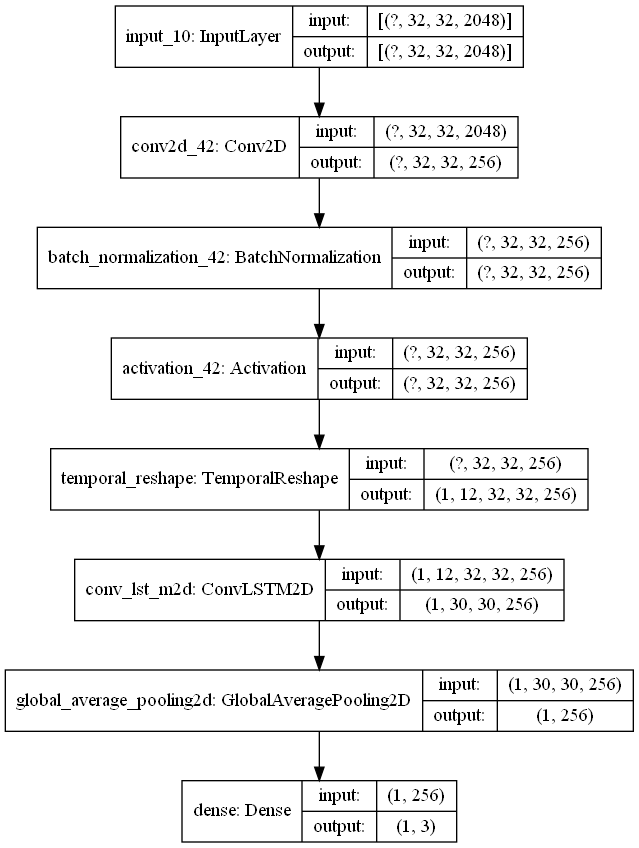

In [47]:
plot_model(dsmodel,show_shapes = True)

In [50]:
NUM_CLASSES = 3

In [51]:
class DSDataGen(Sequence):
    def __init__(self, phase, injury, mode, base_dir, labs_df, filenames_df, pretext_model, preprocess_input = None, 
                 batch_size=1, data_aug = True, num_frames = NUM_FRAMES, num_classes=NUM_CLASSES):
        self.base_dir = base_dir
        self.ph_mode_dir = base_dir +'\\'+phase
        self.filenames = os.listdir(self.ph_mode_dir)
        self.phase = phase
        self.batch_size = batch_size
        self.num_frames = num_frames
        self.num_classes = num_classes
        self.filenames_df = filenames_df
        self.preprocess_input = preprocess_input
        self.pretext_model = pretext_model
        self.MAX_FRAMES = num_frames #NUM_FRAMES
         
        self.mode = mode #['sagittal','coronal','axial']
        self.injury = injury

        self.mllabs = labs_df

        self.indices = list(range(self.filenames_df.shape[0]))
        
        self.data_aug = data_aug
        
        self.startind = 0
        self.endind = self.startind + self.batch_size
        
        self.invGamma100 = 1.0 
        self.invGamma115 = 1.0/1.15
        self.invGamma085 = 1.0/0.85
        self.table100 = np.array([((k / 255.0) ** self.invGamma100) * 255 for k in np.arange(0, 256)]).astype("uint8")
        self.table115 = np.array([((k / 255.0) ** self.invGamma115) * 255 for k in np.arange(0, 256)]).astype("uint8")
        self.table085 = np.array([((k / 255.0) ** self.invGamma085) * 255 for k in np.arange(0, 256)]).astype("uint8")
        self.gamma_dict100 = dict(zip(range(256),self.table100))
        self.gamma_dict115 = dict(zip(range(256),self.table115))
        self.gamma_dict085 = dict(zip(range(256),self.table085))

    def get_random_shuffle_order(self,batch_sz):
        blist = list(range(batch_sz))
        random.shuffle(blist)
        #print(blist)
        return blist
    
    def load_volume(self,mode,file_idx):
        filePoolLen = self.filenames_df.shape[0]
        #print(file_idx)
        #file_idx = file_idx%filePoolLen 
        npy_file = np.load(self.ph_mode_dir+'\\'+mode+'\\'+self.filenames_df['filename'].iloc[file_idx])
        return npy_file
    
    def get_frames(self,mode,idx):
        image_volume = self.load_volume(mode,idx)
        tot_frames = image_volume.shape[0]
        
        self.num_frames = np.min([tot_frames,self.MAX_FRAMES])
        #self.num_frames = 9*int(np.floor(self.num_frames/9.))
        #print(frame_idxs.shape)

        #ONLY FOR MRNet MODEL
        frame_idxs = np.array(sorted(random.sample(list(range(tot_frames)),self.num_frames)))

        frames = np.array([]).reshape((0,256,256,3))
        for n in range(self.num_frames):
            frame_idx = frame_idxs[n]
            frame = np.array(image_volume[frame_idx,:,:])
            frame = np.expand_dims(frame,axis=2)
            frame = np.append(frame,np.append(frame,frame,axis=2),axis=2)
            
            frames = np.append(frames,np.expand_dims(frame,axis=0),axis=0)
        #print(frames.shape)
        return frames
    
    def __len__(self):
        return len(self.filenames_df)
    
    def __getitem__(self,idx):
        
        self.startind = idx*self.batch_size
        self.endind = self.startind + self.batch_size
        
        #DECLARE VARIABLES
        batch_imgs = np.array([]).reshape((0,256,256,3))
        
        ds_batch_labs = ds_batch_labs = self.mllabs[['abn','acl','men']].iloc[idx].values.reshape((1,-1))
        
        #GET CLIP FRAMES
        batch_imgs = np.append(batch_imgs,self.get_frames(self.mode,idx),axis=0)

        sind = 0
        eind = 0
        tot_frames = batch_imgs.shape[0]

        #AUGMENT FRAMES
        if self.data_aug and self.phase == 'train':
            batch_imgs = self.__augment(batch_imgs)

        #PREPROCESS FRAMES
        batch_imgs = self.preprocess_input(batch_imgs)
        b1out = branch1(batch_imgs)
        b2out = branch2(batch_imgs)
        b3out = branch3(batch_imgs)
        b4out = branch4(batch_imgs)
        b5out = branch5(batch_imgs)
        b6out = branch6(batch_imgs)
        b7out = branch7(batch_imgs)
        b8out = branch8(batch_imgs)
        b9out = branch9(batch_imgs)
        
        bouts = np.concatenate([b1out,b2out,b3out,b4out,b5out,b6out,b7out,b8out,b9out],axis=3)
        
        b1out,b2out,b3out,b4out,b5out,b6out,b7out,b8out,b9out = [None]*9
        
        bouts = conv1x1(bouts)
        
        bouts = pretext_part2(bouts)
        
        bouts = pretext_part3(bouts)
        
        return bouts, ds_batch_labs 
    
    def on_epoch_end(self):
        idx = np.random.permutation(self.filenames_df.index.values)
        self.mllabs = self.mllabs.reindex(idx)
        self.filenames_df = self.filenames_df.reindex(idx)
        self.mllabs = self.mllabs.reset_index(drop=True)
        self.filenames_df = self.filenames_df.reset_index(drop=True)
        
    def gamma_correction(self,temp_patch):
        
        gamma_val = np.random.choice([0,1,2])
        if gamma_val == 0:
            temp_patch = np.vectorize(self.gamma_dict100.get)(temp_patch.astype('int'))
        if gamma_val == 1:
            temp_patch = np.vectorize(self.gamma_dict115.get)(temp_patch.astype('int'))
        if gamma_val == 2:
            temp_patch = np.vectorize(self.gamma_dict085.get)(temp_patch.astype('int'))

        return temp_patch
    
    def __augment(self,batch_imgs):
        num_imgs = batch_imgs.shape[0]
        rotang = np.random.choice([-20,0,20])
        scale = np.random.choice([1,1.15])
        transformation_matrix=np.array([[scale,           0,             np.random.choice([-15,0,15])],
                                        [0,               scale,         np.random.choice([-15,0,15])],
                                        [0,               0,                       1                 ]])
        for i in range(num_imgs):
            batch_imgs[i] = rotate(batch_imgs[i],rotang,preserve_range=True)
            batch_imgs[i] = warp(batch_imgs[i], AffineTransform(matrix=transformation_matrix).inverse, preserve_range=True)
            #print(batch_labs)
                
        return batch_imgs

In [52]:
tdg = DSDataGen('train', None, 'sagittal', mrnet_path, tr_multilabel, tr_filenames_df, None, preprocess_input = ppi_irv2, 
                 batch_size=1, data_aug = True, num_frames = NUM_FRAMES, num_classes=NUM_CLASSES)

In [53]:
positive_weights = {}
negative_weights = {}
class_names = ['abn','acl','men']
for i in range(3):
    positive_weights[class_names[i]] = cw[i,0]
    negative_weights[class_names[i]] = cw[i,1]
    
print(positive_weights)
print(negative_weights)

{'abn': 1.0, 'acl': 4.4326923076923075, 'men': 1.8463476070528968}
{'abn': 4.207373271889401, 'acl': 1.0, 'men': 1.0}


In [54]:
vdg = DSDataGen('valid',None,'sagittal',mrnet_path, val_multilabel, val_filenames_df, None,
                preprocess_input = ppi_irv2, batch_size=1, num_frames = NUM_FRAMES,
                data_aug = False, num_classes=NUM_CLASSES)

### Weighted Binary Crossentropy Loss

In [60]:
def loss_fn(y_true,y_pred):
    #print(y_true.numpy(),y_pred)
    loss = 0
    loss -= (positive_weights['abn']*y_true[0]*K.log(y_pred[0]) + negative_weights['abn']*(1-y_true[0])*K.log(1-y_pred[0]))
    loss -= (positive_weights['acl']*y_true[1]*K.log(y_pred[1]) + negative_weights['acl']*(1-y_true[1])*K.log(1-y_pred[1]))
    loss -= (positive_weights['men']*y_true[2]*K.log(y_pred[2]) + negative_weights['men']*(1-y_true[2])*K.log(1-y_pred[2]))
    
    return loss

In [55]:
pos_wts = list(positive_weights.values())
neg_wts = list(negative_weights.values())
print(pos_wts,neg_wts)

[1.0, 4.4326923076923075, 1.8463476070528968] [4.207373271889401, 1.0, 1.0]


In [56]:
def loss_fn2(y_true,y_pred):
    loss = 0
    loss -= K.sum(pos_wts*y_true*K.log(y_pred))
    loss -= K.sum(neg_wts*(1-y_true)*K.log(1-y_pred))
    
    return loss

### model.fit()

In [57]:
dsmodel.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate =tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.00001, decay_steps = 1130,decay_rate=0.95,staircase=True)),
                         loss=loss_fn2,
                         metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()])

In [60]:
history = dsmodel.fit(tdg,epochs = 30,initial_epoch=10, shuffle=True, callbacks = get_callbacks(), validation_data=vdg)

Epoch 11/30
1130/1130 [==============================] - ETA: 0s - loss: 2.7749 - binary_accuracy: 0.7103 - auc: 0.7851
Epoch 00011: val_binary_accuracy improved from -inf to 0.64167, saving model to D:\SiladittyaJRF\ds\COnvLSTM2D primary model\saved_models\sagittal_best_modelX_3009200300.h5
1130/1130 [==============================] - 3475s 3s/step - loss: 2.7749 - binary_accuracy: 0.7103 - auc: 0.7851 - val_loss: 3.8977 - val_binary_accuracy: 0.6417 - val_auc: 0.7503
Epoch 12/30
1130/1130 [==============================] - ETA: 0s - loss: 2.7076 - binary_accuracy: 0.7186 - auc: 0.7971
Epoch 00012: val_binary_accuracy improved from 0.64167 to 0.68056, saving model to D:\SiladittyaJRF\ds\COnvLSTM2D primary model\saved_models\sagittal_best_modelX_3009200300.h5
1130/1130 [==============================] - 3473s 3s/step - loss: 2.7076 - binary_accuracy: 0.7186 - auc: 0.7971 - val_loss: 3.5488 - val_binary_accuracy: 0.6806 - val_auc: 0.7301
Epoch 13/30
1130/1130 [==========================

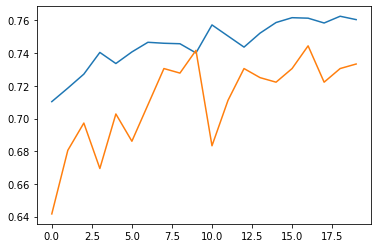

In [61]:
plt.plot(history.history['binary_accuracy']) #+history2.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy']) #+history2.history['val_binary_accuracy'])

## Metrics

In [65]:
dsmodel = tf.keras.models.load_model('path/to/best/model.h5',compile=False,custom_objects= {'TemporalReshape':TemporalReshape})

In [66]:
y = np.array([]).reshape((0,3))

pred = np.array([]).reshape((0,3))

for i in range(120):
    i1,jpp_out_true = vdg.__getitem__(i)
    #print(gtp_out_true.shape)
    y = np.append(y,jpp_out_true,axis=0)
    jpp_pred = dsmodel(i1)
    
    pred = np.append(pred,jpp_pred.numpy(),axis=0)
    #menpred = np.append(menpred,gtp_pred.numpy()[0][2].reshape((1,1)),axis=0)

class_labels = ['abnormality','acl tear','meniscus tear']

In [67]:
perf_metrics_df = get_performance_metrics(y, pred, class_labels, tp=TP,tn=TN, 
                                          fp=FP, fn=FN, acc=get_accuracy, 
                                          prevalence=get_prevalence, 
                                          spec=specificity,sens=sensitivity, 
                                          ppv=get_ppv, npv=get_npv, 
                                          auc=roc_auc_score, f1=f1_score,
                                          thresholds=[])

In [68]:
perf_metrics_df

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
abnormality,85,14,11,10,0.825,0.792,0.895,0.56,0.885,0.583,0.8,0.89,0.5
acl tear,38,47,19,16,0.708,0.45,0.704,0.712,0.667,0.746,0.81,0.685,0.5
meniscus tear,40,40,28,12,0.667,0.433,0.769,0.588,0.588,0.769,0.726,0.667,0.5


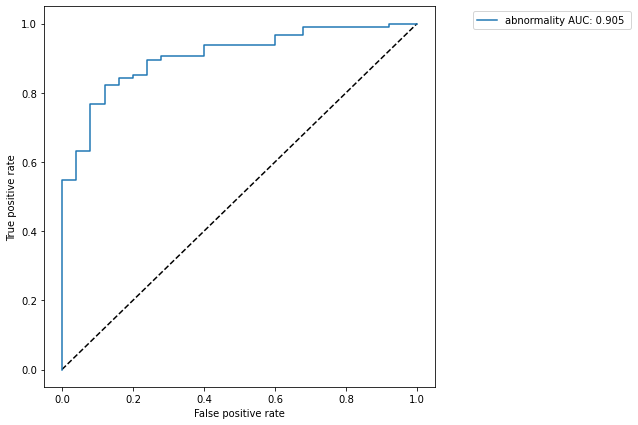

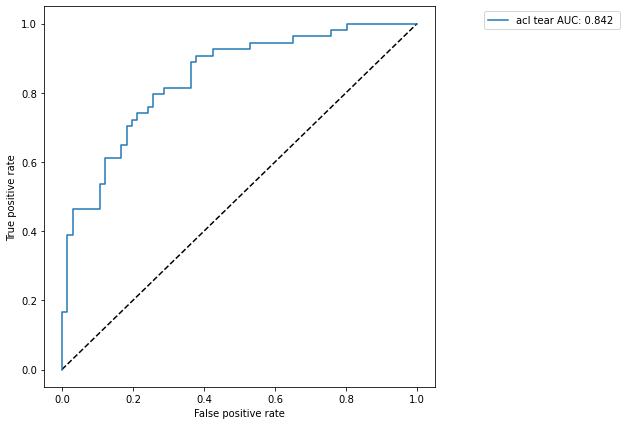

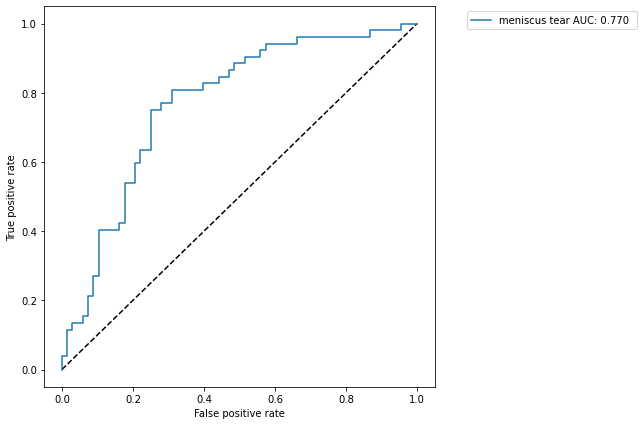

In [77]:
get_roc_curve(y,pred,class_labels)

In [72]:
get_confidence_intervals(y,pred,class_names)

{'AUC':        Mean AUC (CI 5%-95%)
 abn  0.8833 (0.8660-0.8990)
 acl  0.7647 (0.7398-0.7875)
 men  0.7497 (0.7268-0.7770),
 'Sensitivity':     Mean Sensitivity (CI 5%-95%)
 abn       0.9686 (0.9595-0.9785)
 acl       0.5190 (0.4843-0.5534)
 men       0.4827 (0.4502-0.5128),
 'Specificity':     Mean Specificity (CI 5%-95%)
 abn       0.3576 (0.3075-0.4137)
 acl       0.9091 (0.8889-0.9273)
 men       0.8084 (0.7878-0.8340),
 'Accuracy':     Mean Accuracy (CI 5%-95%)
 abn    0.8424 (0.8297-0.8569)
 acl    0.7322 (0.7089-0.7501)
 men    0.6670 (0.6476-0.6868)}

In [1]:
# plot_perf_metrics_errbars(y,pred,class_names)